In [35]:
import torch
import torch.utils.data
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [43]:
n_latent_gaussian = 2  # size of the latent gaussian variable
# n_latent_one_hot = 0  # length of the latent one-hot code

batch_size = 64  # samples of data distribution at each iteration
latent_batch_size = 1024  # number of possible latent codes to try for each sample

n_epochs = 300

In [37]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

torch.manual_seed(42)

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, drop_last=True)

In [45]:
def sample_latent_codes(n_latent_samples):
    gaussian_samples = np.random.randn(n_latent_samples, n_latent_gaussian)
#     one_hot_samples = np.eye(n_latent_one_hot)[np.random.choice(n_latent_one_hot, n_latent_samples)]
    return torch.from_numpy(gaussian_samples).float()
#     return torch.from_numpy(np.hstack([gaussian_samples, one_hot_samples])).float()

In [39]:
# D_in is input dimension;
# H is hidden dimension;
# D_out is output dimension.

D_in, H, D_out = n_latent_gaussian + n_latent_one_hot, 100, 28 * 28

model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
).to(device)

In [40]:
params = list(model.parameters())
    
optimizer = torch.optim.Adam(params, betas=(0.5, 0.999))
loss_fn = torch.nn.L1Loss(reduction='none')

In [50]:
loss_log = []

for epoch in range(1, n_epochs + 1):
    current_epoch_losses = []
    
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device) 
        data = data.reshape(data.shape[0], -1)  # flatten the image
        
        x_train = sample_latent_codes(batch_size * latent_batch_size).to(device)
        y_train = data.repeat(latent_batch_size, 1)
        y_pred = model(x_train)

        loss_all_modes = loss_fn(y_pred, y_train)

        # Zero the gradients before running the backward pass.
        optimizer.zero_grad()
        
        selective_loss = loss_all_modes.mean(dim=1).reshape(latent_batch_size, batch_size).min(dim=0)[0].sum()
        selective_loss.backward()
        
        current_epoch_losses.append(selective_loss)
        
        optimizer.step()
    
    loss_log.append(torch.tensor(current_epoch_losses).mean().detach().numpy())
    
    if True:  # if epoch % 10 == 0:
        print('Epoch: {} / Loss: {:.2f}'.format(epoch, loss_log[-1]))

Epoch: 1 / Loss: 26.32
Epoch: 2 / Loss: 26.05
Epoch: 3 / Loss: 26.02
Epoch: 4 / Loss: 26.01
Epoch: 5 / Loss: 25.99
Epoch: 6 / Loss: 24.07
Epoch: 7 / Loss: 21.88
Epoch: 8 / Loss: 21.09
Epoch: 9 / Loss: 20.29
Epoch: 10 / Loss: 19.80
Epoch: 11 / Loss: 19.34
Epoch: 12 / Loss: 18.85
Epoch: 13 / Loss: 18.39
Epoch: 14 / Loss: 18.04
Epoch: 15 / Loss: 17.80
Epoch: 16 / Loss: 17.61
Epoch: 17 / Loss: 17.46
Epoch: 18 / Loss: 17.33
Epoch: 19 / Loss: 17.22
Epoch: 20 / Loss: 17.12
Epoch: 21 / Loss: 17.03
Epoch: 22 / Loss: 16.94
Epoch: 23 / Loss: 16.87
Epoch: 24 / Loss: 16.80
Epoch: 25 / Loss: 16.74
Epoch: 26 / Loss: 16.69
Epoch: 27 / Loss: 16.64
Epoch: 28 / Loss: 16.60
Epoch: 29 / Loss: 16.56
Epoch: 30 / Loss: 16.52
Epoch: 31 / Loss: 16.48
Epoch: 32 / Loss: 16.44
Epoch: 33 / Loss: 16.40
Epoch: 34 / Loss: 16.37
Epoch: 35 / Loss: 16.33
Epoch: 36 / Loss: 16.31
Epoch: 37 / Loss: 16.28
Epoch: 38 / Loss: 16.25
Epoch: 39 / Loss: 16.23
Epoch: 40 / Loss: 16.21
Epoch: 41 / Loss: 16.20
Epoch: 42 / Loss: 16.17
E

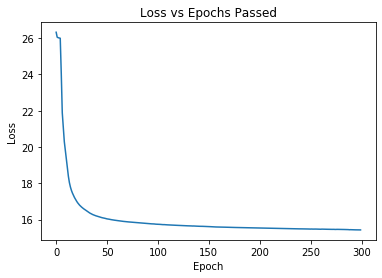

In [51]:
plt.figure()
plt.title('Loss vs Epochs Passed')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(len(loss_log)), loss_log)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


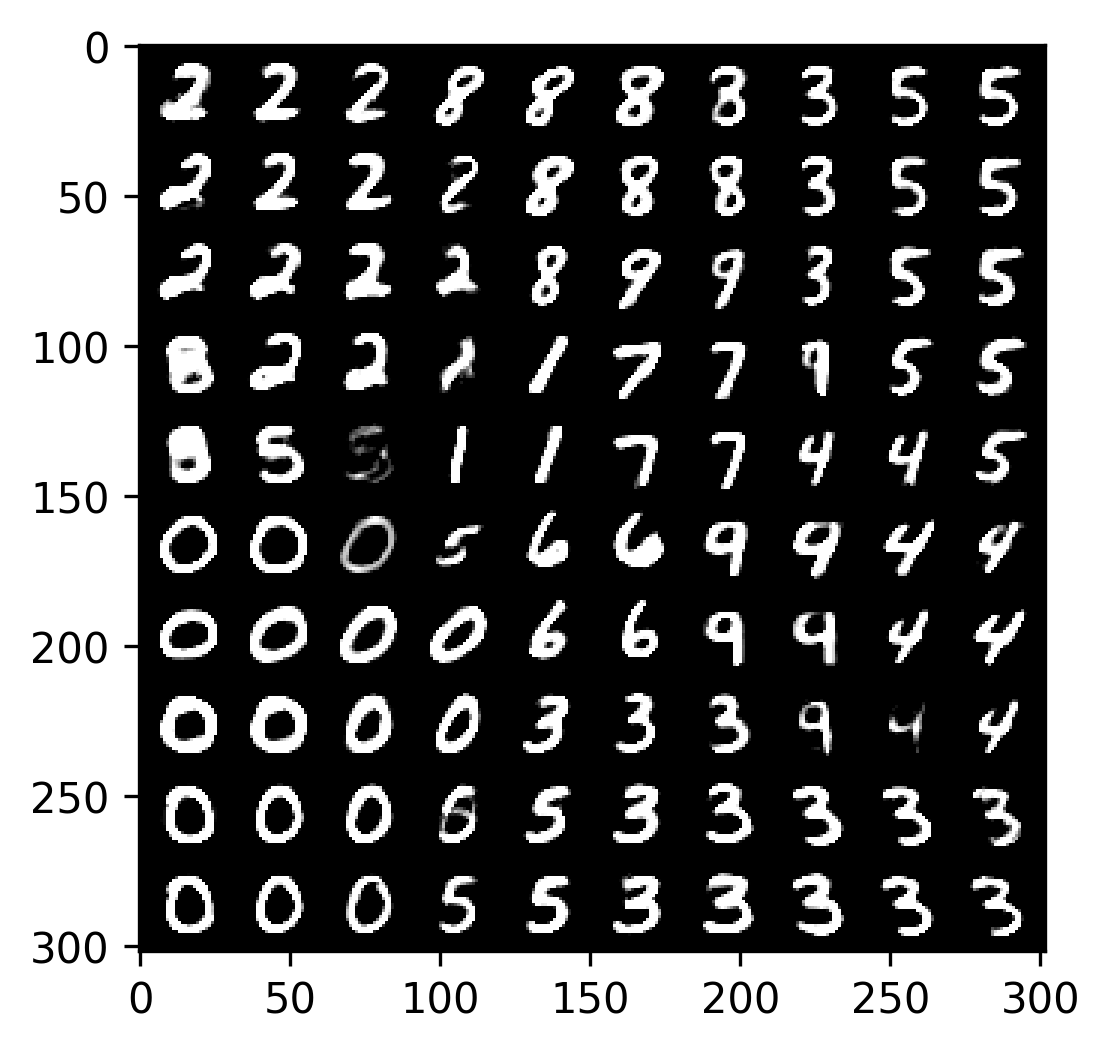

In [72]:
import torchvision

grid_width = 10
x1 = np.linspace(-2, 2, grid_width)
x2 = np.linspace(-2, 2, grid_width)
xv1, xv2 = np.meshgrid(x1, x2)

x_test = torch.from_numpy(np.hstack([xv1.reshape(-1, 1), xv2.reshape(-1, 1)])).float().to(device)
y_pred = model(x_test).detach().cpu().reshape(-1, 1, 28, 28)

plt.figure(dpi=300)
img = torchvision.utils.make_grid(y_pred, nrow=grid_width, padding=2, normalize=False, range=None, scale_each=False, pad_value=0)
plt.imshow(np.transpose(img, (1,2,0)))
                            
plt.show()